# Tdf 0 0 2_Data Model
<hr style="border-top-width: 4px; border-top-color: #34609b;">
This tutorial shows the possibility to use data models which are more
complex than flat ntuples with TDataFrame




**Author:** Danilo Piparo  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-mirror/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer (Beta)</a> from the macro found in the ROOT repository  on Thursday, January 05, 2017 at 03:05 PM.</small></i>

 ## Preparation
 This notebook can be compiled with this invocation
 `g++ -o tdf002_dataModel tdf002_dataModel.C `root-config --cflags --libs` -lTreePlayer`

In [1]:
%%cpp -d
#include "../TDataFrame.hxx"

using FourVector = ROOT::Math::XYZTVector;
using FourVectors = std::vector<FourVector>;
using CylFourVector = ROOT::Math::RhoEtaPhiVector;

  A simple helper function to fill a test tree: this makes the example 
 stand-alone.
 

In [2]:
%%cpp -d
void fill_tree(const char* filename, const char* treeName) {
   TFile f(filename,"RECREATE");
   TTree t(treeName,treeName);
   FourVectors tracks;
   t.Branch("tracks", &tracks);

   const double M = 0.13957;  // set pi+ mass
   TRandom3 R(1);

   for (auto i : ROOT::TSeqI(50)) {
      auto nPart = R.Poisson(15);
      tracks.clear();
      tracks.reserve(nPart);
      for (auto j : ROOT::TSeqI(nPart)) {
         double px = R.Gaus(0,10);
         double py = R.Gaus(0,10);
         double pt = sqrt(px*px +py*py);
         double eta = R.Uniform(-3,3);
         double phi = R.Uniform(0.0 , 2*TMath::Pi() );
         CylFourVector vcyl( pt, eta, phi);
         // set energy
         double E = sqrt( vcyl.R()*vcyl.R() + M*M);
         FourVector q( vcyl.X(), vcyl.Y(), vcyl.Z(), E);
         // fill track vector
         tracks.emplace_back(q);
      }
      t.Fill();
   }

   t.Write();
   f.Close();
   return;
}

We prepare an input tree to run on

In [3]:
auto fileName = "myfile_dataModel.root";
auto treeName = "myTree";
fill_tree(fileName,treeName);

We read the tree from the file and create a tdataframe, a class that 
 allows us to interact with the data contained in the tree.

In [4]:
TFile f(fileName);
TDataFrame d(treeName, &f, {"tracks"});

 ## Operating on branches which are collection of objects
 Here we deal with the simplest of the cuts: we decide to accept the event
 only if the number of tracks is greater than 5.

In [5]:
auto n_cut = [](const FourVectors & tracks) { return tracks.size() > 5; };
auto nentries = d.Filter(n_cut, {"tracks"})
                .Count();

std::cout << *nentries.get() << " passed all filters" << std::endl;

50 passed all filters


Another possibility consists in creating a new column containing the
 quantity we are interested in.
 In this example, we will cut on the number of tracks and plot their
 transverse momentum.

In [6]:
auto getPt = [](const FourVectors& tracks) {
   std::vector<double> pts;
   pts.reserve(tracks.size());
   for (auto& t:tracks)
      pts.emplace_back(t.Pt());
   return pts;
   };

auto& augmented_d = d.AddBranch("tracks_n", [](const FourVectors& tracks){return (int)tracks.size();})
                     .Filter([](int tracks_n){return tracks_n > 2;}, {"tracks_n"})
                     .AddBranch("tracks_pts", getPt);

auto trN = augmented_d.Histo("tracks_n",40,-.5,39.5);
auto trPts = augmented_d.Histo("tracks_pts");

TCanvas c1;
trN->Draw();
c1.Print("tracks_n.png");

TCanvas c2;
trPts->Draw();
c2.Print("tracks_pt.png");

return 0;

Info in <TCanvas::Print>: png file tracks_n.png has been created
Info in <TCanvas::Print>: png file tracks_pt.png has been created


Draw all canvases 

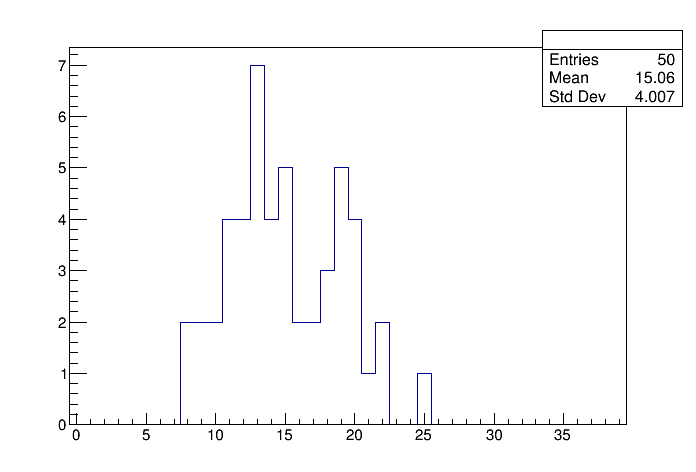

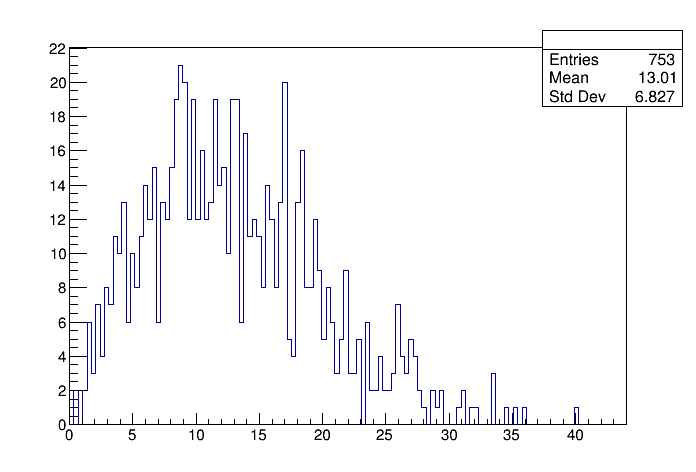

In [7]:
gROOT->GetListOfCanvases()->Draw()